In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


## Preparing Cartoon image as training data

In [3]:
!mkdir cartoons
!mkdir cartoons/1
!unzip -n -q /content/drive/My\ Drive/cartoonGAN/safebooru.zip -d cartoons/1/

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import math

image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

cartoon_dataset = ImageFolder('cartoons/', transform=transformer)

cartoon_train_loader = DataLoader(
    cartoon_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

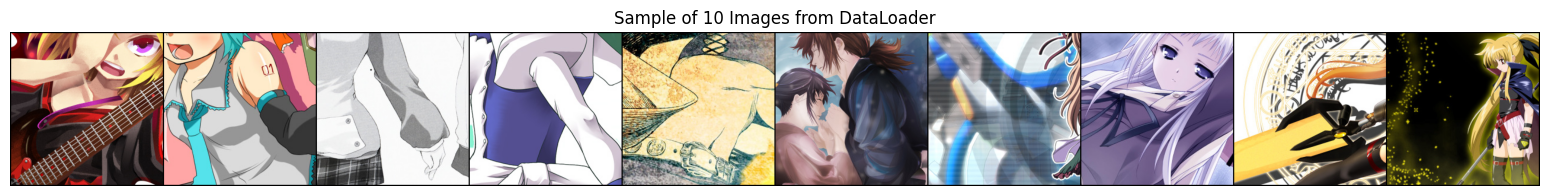

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch

def show_image_grid(dataloader, n_images=4):
    data_iter = iter(dataloader)
    images, _ = next(data_iter)

    images = images[:n_images]

    grid_img = make_grid(images, nrow=n_images, padding=2)
    np_img = grid_img.numpy()

    plt.figure(figsize=(n_images * 2, 2))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.title(f"Sample of {n_images} Images from DataLoader")
    plt.show()

show_image_grid(cartoon_train_loader, 10)

## Preparing Smoothed Cartoon image as training data

In [11]:
!mkdir cartoons_smoothed
!mkdir cartoons_smoothed/1
!unzip -n -q /content/drive/My\ Drive/cartoonGAN/safebooru_smoothed.zip -d cartoons_smoothed/1/

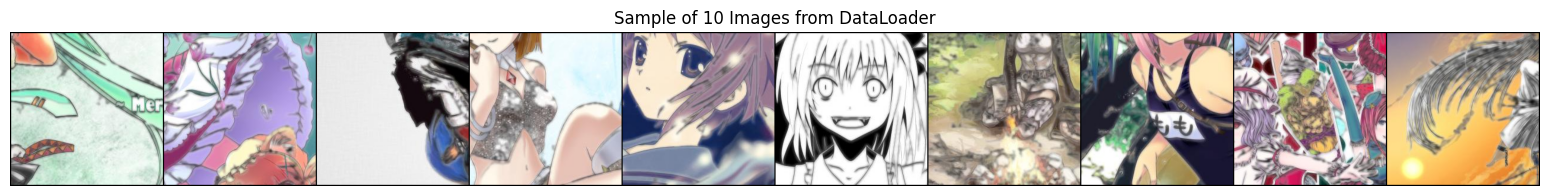

In [13]:
smoothed_cartoon_dataset = ImageFolder('cartoons_smoothed/', transform=transformer)

total_samples = len(smoothed_cartoon_dataset)
num_train = math.floor(0.8 * total_samples)
num_val = total_samples - num_train

smoothed_cartoon_train_set, smoothed_cartoon_val_set = random_split(smoothed_cartoon_dataset, [num_train, num_val])

smoothed_cartoon_train_loader = DataLoader(
    smoothed_cartoon_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
show_image_grid(smoothed_cartoon_train_loader,10)

## Preparing real world images as trainig data

In [14]:
!mkdir photos
!mkdir photos/1
!unzip -n -q /content/drive/My\ Drive/cartoonGAN/coco.zip -d photos/1

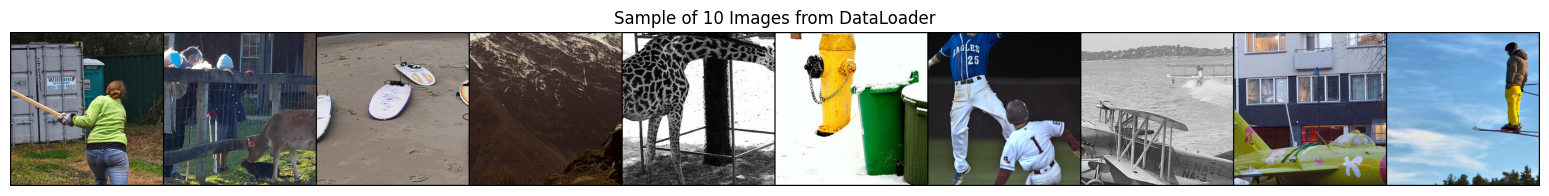

In [ ]:
photo_dataset = ImageFolder('photos/', transform=transformer)

total_samples = len(photo_dataset)
num_train = math.floor(0.8 * total_samples)
num_val   = math.floor(0.1 * total_samples)
num_test  = total_samples - num_train - num_val

photo_train_set, photo_val_set, photo_test_set = random_split(
    photo_dataset, [num_train, num_val, num_test]
)

photo_train_loader = DataLoader(
    photo_train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

photo_val_loader = DataLoader(
    photo_val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

photo_test_loader = DataLoader(
    photo_test_set,
    batch_size=batch_size,
    shuffle=False,     
    num_workers=0
)

show_image_grid(photo_train_loader, 10)

## Model Architecture

##Generator

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block_gen(in_channels, out_channels, kernel_size=3, stride=1, norm=True, activation=True, padding_type='reflect'):
    pad = kernel_size // 2
    if padding_type == 'reflect':
        padding = nn.ReflectionPad2d(pad)
    else:
        padding = nn.ZeroPad2d(pad)

    layers = [padding, nn.Conv2d(in_channels, out_channels, kernel_size, stride)]

    if norm:
        layers.append(nn.InstanceNorm2d(out_channels, affine=True))

    if activation:
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)


class ResidualBlock(nn.Module):
    def __init__(self, channels, padding_type='reflect'):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            conv_block_gen(channels, channels, kernel_size=3, stride=1, padding_type=padding_type),
            conv_block_gen(channels, channels, kernel_size=3, stride=1, activation=False, padding_type=padding_type)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_resblocks=8, base_filters=64):
        super(Generator, self).__init__()

        # Initial 7x7 conv
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_filters, kernel_size=7, stride=1),
            nn.InstanceNorm2d(base_filters, affine=True),
            nn.ReLU(inplace=True)
        )

        # Downsampling
        self.down = nn.Sequential(
            conv_block_gen(base_filters, base_filters * 2, kernel_size=3, stride=2),   # k3n128s2
            conv_block_gen(base_filters * 2, base_filters * 2, kernel_size=3, stride=1), # k3n128s1

            conv_block_gen(base_filters * 2, base_filters * 4, kernel_size=3, stride=2),   # k3n256s2
            conv_block_gen(base_filters * 4, base_filters * 4, kernel_size=3, stride=1),   # k3n256s1
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(*[
            ResidualBlock(base_filters * 4) for _ in range(num_resblocks)
        ])

        # Upsampling using nearest + conv
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            conv_block_gen(base_filters * 4, base_filters * 2, kernel_size=3, stride=1),

            nn.Upsample(scale_factor=2, mode='nearest'),
            conv_block_gen(base_filters * 2, base_filters, kernel_size=3, stride=1),
        )

        # Final conv: 7x7 → output
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_filters, out_channels, kernel_size=7, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down(x)
        x = self.res_blocks(x)
        x = self.up(x)
        x = self.output(x)
        return x


In [17]:
G = Generator()
#print(G)

## Discriminator

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv_block_dis(in_channels, out_channels, kernel_size=3, stride=1, norm_type='batch', lrelu_alpha=0.2, padding_type='reflect'):
    pad = kernel_size // 2
    if padding_type == 'reflect':
        padding_layer = nn.ReflectionPad2d(pad)
    else:
        padding_layer = nn.ZeroPad2d(pad)

    layers = [padding_layer, nn.Conv2d(in_channels, out_channels, kernel_size, stride)]

    if norm_type == 'instance':
        layers.append(nn.InstanceNorm2d(out_channels, affine=True))
    elif norm_type == 'batch':
        layers.append(nn.BatchNorm2d(out_channels))

    layers.append(nn.LeakyReLU(negative_slope=lrelu_alpha, inplace=True))

    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, base_filters=32, lrelu_alpha=0.2, pad_type='reflect', norm_type='batch'):
        super(Discriminator, self).__init__()

        # Initial block: k3n32s1
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(1) if pad_type == 'reflect' else nn.ZeroPad2d(1),
            nn.Conv2d(3, base_filters, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=lrelu_alpha, inplace=True)
        )

        # Strided Conv Blocks
        self.down1 = conv_block_dis(base_filters, base_filters * 2, kernel_size=3, stride=2, norm_type=norm_type, lrelu_alpha=lrelu_alpha, padding_type=pad_type)
        self.down2 = conv_block_dis(base_filters * 2, base_filters * 4, kernel_size=3, stride=2, norm_type=norm_type, lrelu_alpha=lrelu_alpha, padding_type=pad_type)

        # Regular conv + norm + lrelu: k3n256s1
        self.conv_256 = conv_block_dis(base_filters * 4, base_filters * 8, kernel_size=3, stride=1, norm_type=norm_type, lrelu_alpha=lrelu_alpha, padding_type=pad_type)

        # Final conv: k3n1s1
        self.final = nn.Sequential(
            nn.ReflectionPad2d(1) if pad_type == 'reflect' else nn.ZeroPad2d(1),
            nn.Conv2d(base_filters * 8, 1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.conv_256(x)
        x = self.final(x)
        return x


In [19]:
D = Discriminator()
#print(D)

## Loss

In [20]:
import torch

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G = Generator()
D = Discriminator()

G = G.to(device)
D = D.to(device)


Train on GPU.


In [21]:
from torchvision import models
from torch.nn import BCELoss

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = nn.BCEWithLogitsLoss()

  def forward(self, real_out, smooth_out, fake_out, epoch, log_tensorboard=False):
        return self._adv_loss(real_out, smooth_out, fake_out, epoch)

  def _adv_loss(self, real_out, smooth_out, fake_out, epoch, log_tensorboard=False):
      batch_size = real_out.size(0)
      labels_real = torch.ones((batch_size, 1, 64, 64), device=real_out.device)
      labels_fake = torch.zeros((batch_size, 1, 64, 64), device=real_out.device)

      loss_real = self.bce(real_out, labels_real)
      loss_smooth = self.bce(smooth_out, labels_fake)
      loss_fake = self.bce(fake_out, labels_fake)

      total_loss = loss_real + loss_smooth + loss_fake
      return total_loss

In [22]:
import torch
from torchvision import models

vgg16 = models.vgg16(pretrained=True).to(device)
feature_extractor = vgg16.features[:24]

for param in feature_extractor.parameters():
    param.requires_grad = False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 184MB/s]


In [23]:
import torch
import torch.nn as nn

class GeneratorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = 0.000005
        self.bce = nn.BCEWithLogitsLoss()
        self.feat_extractor = vgg16.features[:24]
        for param in self.feat_extractor.parameters():
            param.requires_grad = False

    def forward(self, d_out_fake, real_img, fake_img, epoch, init_phase=False):
        if init_phase:
            loss_content = self._content_loss(real_img, fake_img)
            loss_adv = 0.0
            total_loss = loss_content
        else:
            loss_adv = self._adv_loss(d_out_fake)
            loss_content = self._content_loss(real_img, fake_img)
            total_loss = loss_adv + self.weight * loss_content

        return total_loss

    def _adv_loss(self, d_out_fake):
        batch_size = d_out_fake.size(0)
        labels_real = torch.ones((batch_size, 1, 64, 64), device=d_out_fake.device)
        return self.bce(d_out_fake, labels_real)

    def _content_loss(self, real_img, fake_img):
        return (self.feat_extractor(fake_img) - self.feat_extractor(real_img)).norm(p=1)


In [24]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [25]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Train

In [ ]:
from __future__ import annotations
import os, time, itertools, math
from pathlib import Path
from typing import List

import torch, torch.nn as nn
from torchvision.utils import save_image


def _save_grid(real: torch.Tensor, fake: torch.Tensor, epoch: int, root: Path):
    """Saves a side‑by‑side grid of (photo | cartoon) for quick QA."""
    root.mkdir(parents=True, exist_ok=True)
    grid = torch.cat([real.cpu(), fake.cpu()], dim=0)  
    save_image(grid, root / f"epoch_{epoch:03d}.png", nrow=real.size(0), normalize=True, value_range=(0,1))


def train(
    *,
    generator: nn.Module,
    discriminator: nn.Module,
    generator_loss: GeneratorLoss,
    discriminator_loss: DiscriminatorLoss,
    photo_loader_train,
    photo_loader_val,
    cartoon_loader,
    smooth_loader,
    g_opt: torch.optim.Optimizer,
    d_opt: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int = 100,
    warmup_epochs: int = 10,
    checkpoint_dir: str = "checkpoints",
    print_every: int = 100,
    start_epoch: int = 0,
):
    """Full CartoonGAN training loop – replicates the original functionality."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    # --- loss objects ---
    bce = nn.BCEWithLogitsLoss()

    real, fake = 1.0, 0.0  

    losses: List[float] = []
    val_losses: List[float] = []
    best_val = math.inf
    start = time.time()

    # === Warm‑up ============================================================
    if warmup_epochs:
        print("[Warm‑up] training generator with content loss only …")
        generator.train().to(device)
        for ep in range(warmup_epochs):
            for batch, _ in photo_loader_train:
                batch = batch.to(device)
                g_opt.zero_grad()
                fake_cartoon = generator(batch)
                loss_c = generator_loss._content_loss(batch, fake_cartoon)
                loss_c.backward(); g_opt.step()
            print(f"  ↳ epoch {ep+1}/{warmup_epochs}, content‑loss = {loss_c.item():.4f}")

    # === Adversarial phase ==================================================
    print("[Adversarial] starting GAN training …")
    for epoch in range(start_epoch, num_epochs):
        generator.train(); discriminator.train()
        for i, ((photo,_), (cartoon,_), (smooth,_)) in enumerate(zip(photo_loader_train, cartoon_loader, smooth_loader)):
            b = photo.size(0)
            photo, cartoon, smooth = photo.to(device), cartoon.to(device), smooth.to(device)

            # -- D step -------------------------------------------------------
            d_opt.zero_grad()
            d_real = discriminator(cartoon)
            d_edge = discriminator(smooth)
            d_fake = discriminator(generator(photo).detach())
            d_loss = (
                bce(d_real,  torch.ones_like(d_real)*real) +
                bce(d_edge,  torch.zeros_like(d_edge)) +
                bce(d_fake,  torch.zeros_like(d_fake))
            )
            d_loss.backward(); d_opt.step()

            # -- G step -------------------------------------------------------
            g_opt.zero_grad()
            g_fake = generator(photo)
            d_out = discriminator(g_fake)
            g_loss = generator_loss(d_out, photo, g_fake, epoch)
            g_loss.backward(); g_opt.step()

            if i % print_every == 0:
                now = time.time(); took = now - start; start = now
                losses.append((d_loss.item(), g_loss.item()))
                print(f"Ep {epoch+1}/{num_epochs} | idx {i} | d {d_loss.item():.4f} | g {g_loss.item():.4f} | {took:.1f}s | total {len(losses)}")

        # ---- sample & validate -------------------------------------------
        with torch.no_grad():
            generator.eval(); discriminator.eval()
            photoval, _ = next(iter(photo_loader_val))
            photoval = photoval.to(device)

            fake_val = generator(photoval).clamp(0, 1)
            print(f"Fake_val stats → min: {fake_val.min():.4f}, max: {fake_val.max():.4f}, mean: {fake_val.mean():.4f}")

            _save_grid(photoval, fake_val, epoch+1, checkpoint_dir/'samples')

            # Use same feature extractor as training
            val_c = generator_loss._content_loss(photoval, fake_val).item() # Use photoval as input, fake_val as output

            val_losses.append(val_c)
            print(f"  ↳ validation content‑loss = {val_c:.4f}")

        # ---- checkpoints ---------------------------------------------------
        ckpt = {
            'epoch': epoch+1,
            'g_state': generator.state_dict(),
            'd_state': discriminator.state_dict(),
            'g_opt_state': g_opt.state_dict(),
            'd_opt_state': d_opt.state_dict(),
            'train_losses': losses,
            'val_losses': val_losses,
            'best_val': best_val,
        }
        torch.save(ckpt, checkpoint_dir / f'ckpt_{epoch+1:03d}.pth')
        if val_c < best_val:
            best_val = val_c
            torch.save(ckpt, checkpoint_dir / 'best.pth')
            print(f"      ✓ new best checkpoint saved (val‑loss {best_val:.4f})")

    print("Training finished.")


In [ ]:
# Start Training
checkpoint_dir = '/content/drive/MyDrive/cartoonGAN/cartoonGAN_checkpoints'       # Saving Checkpoints
train(
    generator             = G,
    discriminator         = D,
    generator_loss        = generatorLoss,
    discriminator_loss    = discriminatorLoss,
    photo_loader_train    = photo_train_loader,
    photo_loader_val      = photo_val_loader,
    cartoon_loader        = cartoon_train_loader,
    smooth_loader         = smoothed_cartoon_train_loader,
    g_opt                 = g_optimizer,
    d_opt                 = d_optimizer,
    device                = device,
    num_epochs            = 210,
    warmup_epochs         = 10,
    checkpoint_dir        = checkpoint_dir
)



[Warm‑up] training generator with content loss only …
  ↳ epoch 1/10, content‑loss = 974645.7500
  ↳ epoch 2/10, content‑loss = 671855.9375
  ↳ epoch 3/10, content‑loss = 533315.3125
  ↳ epoch 4/10, content‑loss = 431477.6875
  ↳ epoch 5/10, content‑loss = 395246.1250
  ↳ epoch 6/10, content‑loss = 399874.8750
  ↳ epoch 7/10, content‑loss = 397512.4375
  ↳ epoch 8/10, content‑loss = 314243.0000
  ↳ epoch 9/10, content‑loss = 320587.6875
  ↳ epoch 10/10, content‑loss = 303647.7500
[Adversarial] starting GAN training …
Ep 1/210 | idx 0 | d 0.1815 | g 5.4017 | 640.9s | total 1
Ep 1/210 | idx 100 | d 0.0193 | g 7.9837 | 61.0s | total 2
Fake_val stats → min: 0.0058, max: 0.9982, mean: 0.4235
  ↳ validation content‑loss = 407948.0625
      ✓ new best checkpoint saved (val‑loss 407948.0625)
Ep 2/210 | idx 0 | d 0.0263 | g 8.0136 | 61.9s | total 3
Ep 2/210 | idx 100 | d 0.0072 | g 8.4447 | 60.4s | total 4
Fake_val stats → min: 0.0060, max: 0.9982, mean: 0.4234
  ↳ validation content‑loss = 406

In [ ]:
# Resume Training (Optional)
import torch
import os

# Define your checkpoint path
checkpoint_dir = '/content/drive/MyDrive/cartoonGAN/cartoonGAN_checkpoints_original_loss'
checkpoint_file = os.path.join(checkpoint_dir, 'ckpt_004.pth')   # <-- example: loading checkpoint from epoch 4

# Load the checkpoint
checkpoint = torch.load(checkpoint_file, map_location=device)

# Restore model weights
G.load_state_dict(checkpoint['g_state'])
D.load_state_dict(checkpoint['d_state'])

# Restore optimizer states
g_optimizer.load_state_dict(checkpoint['g_opt_state'])
d_optimizer.load_state_dict(checkpoint['d_opt_state'])

# Optionally, resume training from the saved epoch
start_epoch = checkpoint['epoch']

print(f"Checkpoint loaded! Resuming from epoch {start_epoch}")

train(
    generator             = G,
    discriminator         = D,
    generator_loss        = generatorLoss,
    discriminator_loss    = discriminatorLoss,
    photo_loader_train    = photo_train_loader,
    photo_loader_val      = photo_val_loader,
    cartoon_loader        = cartoon_train_loader,
    smooth_loader         = smoothed_cartoon_train_loader,
    g_opt                 = g_optimizer,
    d_opt                 = d_optimizer,
    device                = device,
    num_epochs            = 20,    # total epoch
    warmup_epochs         = 0,     # <--- VERY IMPORTANT: skip warmup when resuming
    checkpoint_dir        = checkpoint_dir,
    start_epoch           = start_epoch,
)


Checkpoint loaded! Resuming from epoch 4
[Adversarial] starting GAN training …
Ep 5/20 | idx 0 | d 1.8240 | g 9.3530 | 2.4s | total 1
Ep 5/20 | idx 100 | d 0.7026 | g 7.3967 | 238.4s | total 2
Fake_val stats → min: 0.0000, max: 0.4902, mean: 0.0103
  ↳ validation content‑loss = 1175154.1250
      ✓ new best checkpoint saved (val‑loss 1175154.1250)
Ep 6/20 | idx 0 | d 0.2132 | g 8.8385 | 250.6s | total 3
Ep 6/20 | idx 100 | d 0.2691 | g 7.8091 | 237.4s | total 4
Fake_val stats → min: 0.0000, max: 0.0000, mean: 0.0000
  ↳ validation content‑loss = 1093369.8750
      ✓ new best checkpoint saved (val‑loss 1093369.8750)
Ep 7/20 | idx 0 | d 0.1712 | g 8.2799 | 238.0s | total 5
Ep 7/20 | idx 100 | d 0.2240 | g 8.6073 | 236.4s | total 6
Fake_val stats → min: 0.0000, max: 0.0000, mean: 0.0000
  ↳ validation content‑loss = 1093369.8750
Ep 8/20 | idx 0 | d 0.0986 | g 8.8717 | 237.0s | total 7
Ep 8/20 | idx 100 | d 0.0743 | g 8.5498 | 236.2s | total 8
Fake_val stats → min: 0.0000, max: 0.0000, mea

## Test

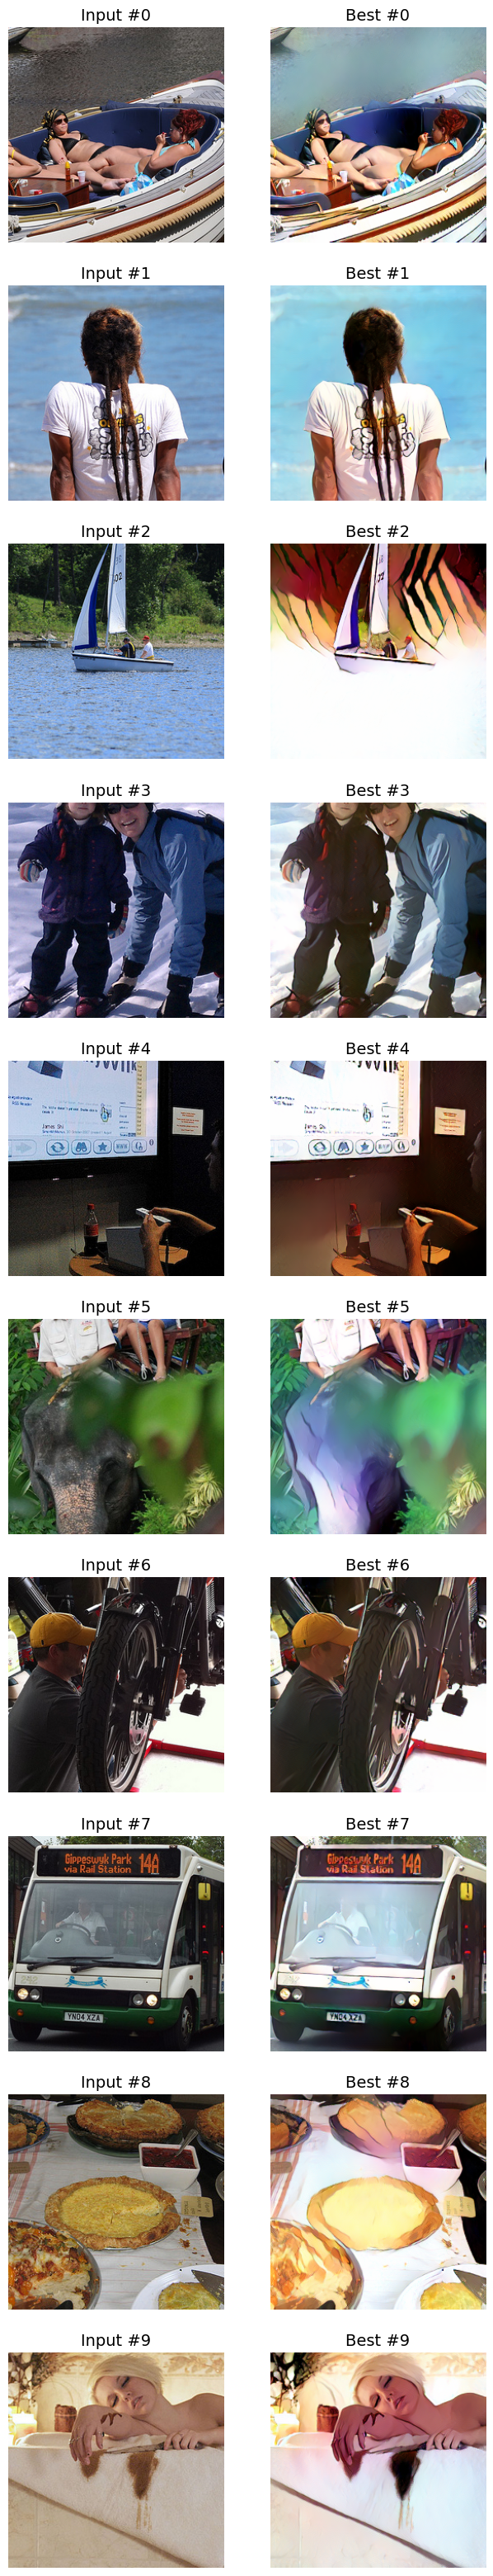

In [ ]:
# === Load best checkpoint from cartoonGAN_checkpoints ===
import os

checkpoint_dir = '/content/drive/MyDrive/cartoonGAN/cartoonGAN_checkpoints'
best_ckpt_path = os.path.join(checkpoint_dir, 'best.pth')  # <- safe join
checkpoint_best = torch.load(best_ckpt_path, map_location=device)

# === Create G_best and load state ===
G_best = Generator().to(device)
G_best.load_state_dict(checkpoint_best['g_state'])
G_best.eval()

# === Prepare test images ===
test_images = next(iter(photo_test_loader))[0].to(device)

# === Generate outputs ===
with torch.no_grad():
    result_best = G_best(test_images).clamp(0, 1)
    result_final = G(test_images).clamp(0, 1)
    input_images = test_images

# === Display with 2 columns: original, best ===
def show_image(ax, tensor_img, title=None):
    img = tensor_img.detach().cpu().numpy()
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    if title:
        ax.set_title(title, fontsize=14)
    ax.axis('off')

fig, axes = plt.subplots(10, 2, figsize=(8, 40))  

plt.subplots_adjust(wspace=0.05, hspace=0.2)

for i in range(10):
    show_image(axes[i, 0], input_images[i], title=f"Input #{i}")
    show_image(axes[i, 1], result_best[i], title=f"Best #{i}")

plt.show()



